Sentiment Analysis for Cyberbullying Detection on Social Media Platforms using ALBERT

In [35]:
#!pip install transformers

In [36]:
import csv
import os
import random
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data.distributed import DistributedSampler
from transformers import AlbertConfig, AlbertForSequenceClassification, AlbertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange, tqdm_notebook
from sklearn.metrics import matthews_corrcoef, accuracy_score, precision_score, recall_score, f1_score

In [37]:
dataset = pd.read_csv("../Datasets/preprocessed_train.csv")
dataset

#dataset = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/IMDB-Dataset.csv")
#dataset = dataset.sample(10_000)
#dataset.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral
1,549e992a42,sooo sad i will miss you here in san diego,soon sad,negative
2,088c60f138,my boss is bullying me,bullying me,negative
3,9642c003ef,what interview leave me alone,leave me alone,negative
4,358bd9e861,sons of why couldnt they put them on the relea...,sons of,negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on denver husband los...,d lost,negative
27477,4f4c4fc327,ive wondered about rake to the client has made...,dont force,negative
27478,f67aae2310,yay good for both of you enjoy the break you p...,yay good for both of you,positive
27479,ed167662a5,but it was worth it,but it was worth it,positive


In [38]:
dataset.dropna(inplace=True)

In [39]:
dataset

,textID,text,selected_text,sentiment
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral
1,549e992a42,sooo sad i will miss you here in san diego,soon sad,negative
2,088c60f138,my boss is bullying me,bullying me,negative
3,9642c003ef,what interview leave me alone,leave me alone,negative
4,358bd9e861,sons of why couldnt they put them on the relea...,sons of,negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on denver husband los...,d lost,negative
27477,4f4c4fc327,ive wondered about rake to the client has made...,dont force,negative
27478,f67aae2310,yay good for both of you enjoy the break you p...,yay good for both of you,positive
27479,ed167662a5,but it was worth it,but it was worth it,positive


In [40]:
dataset.text.value_counts()

text
happy mothers day                                                                                                    36
thanks                                                                                                               13
good morning                                                                                                         12
thank you                                                                                                            10
goodnight                                                                                                             7
                                                                                                                     ..
hanging out with sam billy and veronica not going to school tomorrow to take sam to body shops dang car accidents     1
eeeeeeeeeee it came                                                                                                   1
great reason ill be there trying to

In [41]:
length = []
for i in dataset['text']:
  length.append(len(i.split()))

(array([3205., 4570., 4483., 3866., 3263., 2778., 2508., 1884.,  727.,
          99.]),
 array([ 1. ,  4.1,  7.2, 10.3, 13.4, 16.5, 19.6, 22.7, 25.8, 28.9, 32. ]),
 <BarContainer object of 10 artists>)

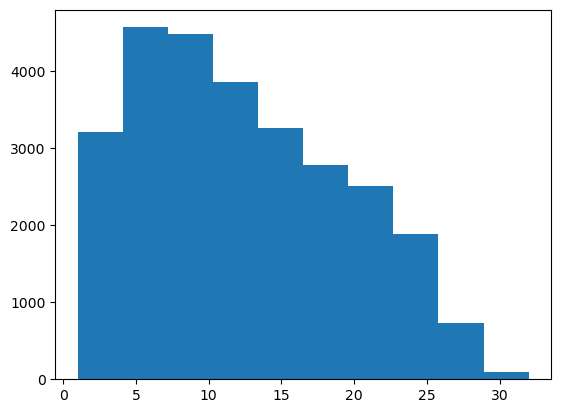

In [42]:
plt.hist(length)

In [43]:
# Optional: Integrate sentiment score (you can use TextBlob or Vader here)
#from textblob import TextBlob

#def get_sentiment(text):
    #return TextBlob(text).sentiment.polarity

#dataset['sentiment'] = dataset['selected_text'].apply(get_sentiment)
#dataset['text'] = dataset['sentiment'].astype(str) + ' ' + dataset['selected_text']  # prepend sentiment to input

In [44]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
dataset["label"] = ord_enc.fit_transform(dataset[["sentiment"]])
dataset[["sentiment", "label"]].head(11)

,sentiment,label
0,0.00,459.0
1,-0.50,45.0
2,0.00,459.0
3,0.00,459.0
4,0.00,459.0
5,1.00,1206.0
6,0.30,963.0
7,0.16,754.0
8,0.00,459.0
9,0.10,659.0


In [45]:
dataset.head()

,textID,text,selected_text,sentiment,label
0,cb774db0d1,0.0 id have responded if i were going,id have responded if i were going,0.0,459.0
1,549e992a42,-0.5 soon sad,soon sad,-0.5,45.0
2,088c60f138,0.0 bullying me,bullying me,0.0,459.0
3,9642c003ef,0.0 leave me alone,leave me alone,0.0,459.0
4,358bd9e861,0.0 sons of,sons of,0.0,459.0


In [46]:
dataset.shape

(27383, 5)

In [47]:
#run this for case 2
dataset = dataset[['selected_text','label']]

In [48]:
dataset.head()

,selected_text,label
0,id have responded if i were going,459.0
1,soon sad,45.0
2,bullying me,459.0
3,leave me alone,459.0
4,sons of,459.0


In [49]:
#train and val split

train_df = dataset.iloc[:19236]
vall_df = dataset.iloc[19236:]
train_df.shape, vall_df.shape

((19236, 2), (8147, 2))

In [50]:
#val test split

val_df = vall_df.iloc[:4122]
test_df = vall_df.iloc[4122:]
val_df.shape, test_df.shape

((4122, 2), (4025, 2))

In [51]:
save_dir = "../data/"
train_df.to_csv(save_dir + "train.csv", index=False)
val_df.to_csv(save_dir + "dev.csv", index=False)

In [52]:
test_df.to_csv(save_dir + "test.csv", index=False)

In [53]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

In [54]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id

In [55]:

class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8-sig") as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                if sys.version_info[0] == 2:
                    line = list(unicode(cell, 'utf-8') for cell in line)
                lines.append(line)
            return lines
          
class TweetProcessor(DataProcessor):
    """Processor for the Amazon Reviews data set."""

    def get_train_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "train.csv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "dev.csv")), "dev")

    def get_test_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "test.csv")), "test")

    def get_labels(self):
        """See base class."""
        return [0, 1, 2]

    #Hack to be compatible with the existing code in transformers library
    def _read_tsv(self, file_path):
        return pd.read_csv(file_path).values.tolist()

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
               continue
            guid = "%s-%s" % (set_type, i)
            text_a = str(line[0])
           # text_b = None
            label = line[1]
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples

In [56]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


In [57]:
def simple_accuracy(preds, labels):
    return (preds == labels).mean()

def acc_and_f1(preds, labels):
    acc = simple_accuracy(preds, labels)
    f1 = f1_score(y_true=labels, y_pred=preds, average='weighted')
    precision = precision_score(y_true=labels, y_pred=preds, average='weighted')
    recall = recall_score(y_true=labels, y_pred=preds, average='weighted')

    return {
        "Accuracy": acc,
        "f1 Score": f1,
        "Precision": precision,
        "Recall": recall
    }

def precision_weighted(preds, labels):
    return precision_score(y_true=labels, y_pred=preds, average='weighted')

def recall_weighted(preds, labels):
    return recall_score(y_true=labels, y_pred=preds, average='weighted')

def f1_weighted(preds, labels):
    return f1_score(y_true=labels, y_pred=preds, average='weighted')

def compute_metrics(task_name, preds, labels):
    assert len(preds) == len(labels), "Predictions and labels must have the same length."
    
    if task_name == "tweet":
        acc = simple_accuracy(preds, labels)  # Define acc before returning
        return {
            "Accuracy": acc,
            "Precision": precision_weighted(preds, labels),
            "Recall": recall_weighted(preds, labels),
            "f1 Score": f1_weighted(preds, labels)
        }
    else:
        raise KeyError(f"Unknown task name: {task_name}")

In [58]:
def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

In [59]:
def convert_examples_to_features(examples, label_list, max_seq_length,
                                 tokenizer, output_mode,
                                 cls_token_at_end=False, pad_on_left=False,
                                 cls_token='[CLS]', sep_token='[SEP]', pad_token=0,
                                 sequence_a_segment_id=0, sequence_b_segment_id=1,
                                 cls_token_segment_id=1, pad_token_segment_id=0,
                                 mask_padding_with_zero=True):
    """ Loads a data file into a list of `InputBatch`s
        `cls_token_at_end` define the location of the CLS token:
            - False (Default, BERT/XLM pattern): [CLS] + A + [SEP] + B + [SEP]
            - True (XLNet/GPT pattern): A + [SEP] + B + [SEP] + [CLS]
        `cls_token_segment_id` define the segment id associated to the CLS token (0 for BERT, 2 for XLNet)
    """

    label_map = {label : i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):

        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[:(max_seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids:   0   0  0    0    0     0       0   0   1  1  1  1   1   1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids:   0   0   0   0  0     0   0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = tokens_a + [sep_token]
        segment_ids = [sequence_a_segment_id] * len(tokens)

        if tokens_b:
            tokens += tokens_b + [sep_token]
            segment_ids += [sequence_b_segment_id] * (len(tokens_b) + 1)

        if cls_token_at_end:
            tokens = tokens + [cls_token]
            segment_ids = segment_ids + [cls_token_segment_id]
        else:
            tokens = [cls_token] + tokens
            segment_ids = [cls_token_segment_id] + segment_ids

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_seq_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            input_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + input_mask
            segment_ids = ([pad_token_segment_id] * padding_length) + segment_ids
        else:
            input_ids = input_ids + ([pad_token] * padding_length)
            input_mask = input_mask + ([0 if mask_padding_with_zero else 1] * padding_length)
            segment_ids = segment_ids + ([pad_token_segment_id] * padding_length)

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        if output_mode == "classification":
            label_id = label_map[example.label]
        elif output_mode == "regression":
            label_id = float(example.label)
        else:
            raise KeyError(output_mode)

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_id=label_id))
    return features

In [60]:

processor = TweetProcessor()
label_list = processor.get_labels()
num_labels = len(label_list)

In [61]:
# AlbertConfig, AlbertForSequenceClassification, AlbertTokenizer
config = AlbertConfig.from_pretrained('albert-base-v2', num_labels=num_labels)
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', config=config)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:
 def load_and_cache_examples(tokenizer, dataset='train'):  
  if dataset == "train":
      examples = processor.get_train_examples(data_dir)
  elif dataset == "dev":
      examples = processor.get_dev_examples(data_dir)
  else:
      examples = processor.get_test_examples(data_dir)
  
  features = convert_examples_to_features(examples, label_list, max_seq_length, tokenizer, output_mode,
            cls_token_at_end=True,            # xlnet has a cls token at the end
            cls_token=tokenizer.cls_token,
            sep_token=tokenizer.sep_token,
            cls_token_segment_id=2,
            pad_on_left=True,               # pad on the left for xlnet
            pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
            pad_token_segment_id=4)
  # Convert to Tensors and build dataset
  all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
  all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
  all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
  if output_mode == "classification":
      all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
  elif output_mode == "regression":
      all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)

  dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
  return dataset

In [63]:
output_mode = 'classification'
max_seq_length = 60
batch_size = 8
max_grad_norm = 1.0
gradient_accumulation_steps=2
num_train_epochs=1
weight_decay=0.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [64]:
learning_rate = 2e-5
adam_epsilon = 1e-8
num_warmup_steps = 0

In [65]:
def train(train_dataset, model, tokenizer):
  """ Train the model """
  train_sampler = RandomSampler(train_dataset)
  train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
  num_training_steps = len(train_dataloader) // gradient_accumulation_steps * num_train_epochs
  # Prepare optimizer and schedule (linear warmup and decay)
  no_decay = ['bias', 'LayerNorm.weight']
  optimizer_grouped_parameters = [
      {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
      {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
      ]
  optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps= num_warmup_steps,num_training_steps = num_training_steps)
  
  global_step = 0
  tr_loss, logging_loss = 0.0, 0.0
  model.zero_grad()
  train_iterator = tqdm_notebook(range(int(num_train_epochs)), desc="Epoch")
  set_seed(42)
  for _ in train_iterator:
    epoch_iterator = tqdm_notebook(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      model.train()
      batch = tuple(t.to(device) for t in batch)
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': None,       # XLM and RoBERTa don't use segment_ids
                'labels':         batch[3]}
      outputs = model(**inputs)
      loss = outputs[0]  # model outputs are always tuple in pytorch-transformers (see doc)
      if gradient_accumulation_steps > 1:
        loss = loss / gradient_accumulation_steps
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
      tr_loss += loss.item()
      if (step + 1) % gradient_accumulation_steps == 0:
          scheduler.step()  # Update learning rate schedule
          optimizer.step()
          model.zero_grad()
          global_step += 1
          
  return global_step, tr_loss / global_step

In [66]:
def evaluate(model, tokenizer, prefix=""):
  results = {}
  eval_dataset = load_and_cache_examples(tokenizer, dataset='dev')
  eval_batch_size = 8
  eval_sampler = SequentialSampler(eval_dataset)
  eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=eval_batch_size)
  eval_loss = 0.0
  nb_eval_steps = 0
  preds = None
  out_label_ids = None
  for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': None,             # XLM and RoBERTa don't use segment_ids
                'labels':         batch[3]}
      outputs = model(**inputs)
      tmp_eval_loss, logits = outputs[:2]
      eval_loss += tmp_eval_loss.mean().item()
    
    nb_eval_steps += 1
    if preds is None:
        preds = logits.detach().cpu().numpy()
        out_label_ids = inputs['labels'].detach().cpu().numpy()
    else:
        preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
        out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)
  eval_loss = eval_loss / nb_eval_steps
  if output_mode == "classification":
      preds = np.argmax(preds, axis=1)
  elif output_mode == "regression":
      preds = np.squeeze(preds)
  result = compute_metrics("tweet", preds, out_label_ids)
  return result

In [67]:
data_dir= '../data/'
model.to(device)
train_dataset = load_and_cache_examples(tokenizer, dataset="train")
global_step, tr_loss = train(train_dataset, model, tokenizer)

KeyError: 45.0

In [33]:
# Evaluation
result = evaluate(model, tokenizer, prefix=global_step)
print(result)

C:\Users\phili\AppData\Local\Temp\ipykernel_24900\3514849440.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):


Evaluating:   0%|          | 0/516 [00:00<?, ?it/s]

{'Accuracy': 0.889589905362776, 'Precision': 0.8895874036358471, 'Recall': 0.889589905362776, 'f1 Score': 0.889588602022941}


In [34]:
# Evaluation
import time
import psutil
from codecarbon import EmissionsTracker

# Start tracking energy consumption
tracker = EmissionsTracker()
tracker.start()

# Measure CPU and RAM usage before evaluation
process = psutil.Process()
cpu_before = psutil.cpu_percent(interval=None)
ram_before = process.memory_info().rss / (1024 * 1024)  # Convert to MB

# Measure inference time
start_time = time.time()

# Evaluation
result = evaluate(model, tokenizer, prefix=global_step)

# Measure inference time
end_time = time.time()
inference_time = end_time - start_time

# Measure CPU and RAM usage after evaluation
cpu_after = psutil.cpu_percent(interval=None)
ram_after = process.memory_info().rss / (1024 * 1024)  # Convert to MB

# Calculate differences
cpu_usage = cpu_after - cpu_before
ram_usage = ram_after - ram_before

# Stop energy tracking
emissions = tracker.stop()

# Print results
print(result)
print(f"Inference Time: {inference_time:.4f} seconds")
print(f"CPU Usage: {cpu_usage:.2f}%")
print(f"RAM Usage: {ram_usage:.2f} MB")
print(f"Energy Consumption: {emissions:.6f} kWh")

[codecarbon INFO @ 20:39:18] [setup] RAM Tracking...
[codecarbon INFO @ 20:39:18] [setup] GPU Tracking...
[codecarbon INFO @ 20:39:18] No GPU found.
[codecarbon INFO @ 20:39:18] [setup] CPU Tracking...
[codecarbon WARNING @ 20:39:18] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 20:39:20] CPU Model on constant consumption mode: AMD Ryzen 5 5500U with Radeon Graphics
[codecarbon INFO @ 20:39:20] >>> Tracker's metadata:
[codecarbon INFO @ 20:39:20]   Platform system: Windows-10-10.0.26100-SP0
[codecarbon INFO @ 20:39:20]   Python version: 3.11.5
[codecarbon INFO @ 20:39:20]   CodeCarbon version: 2.8.1
[codecarbon INFO @ 20:39:20]   Available RAM : 7.342 GB
[codecarbon INFO @ 20:39:20]   CPU count: 12
[codecarbon INFO @ 20:39:20]   CPU model: AMD Ryzen 5 5500U with Radeon Graphics
[codecarbon INFO @ 20:39:20]   GPU count: None
[codecarbon INFO @ 20:39:20]   GPU model: None
[codecar

Evaluating:   0%|          | 0/516 [00:00<?, ?it/s]

[codecarbon INFO @ 20:39:36] Energy consumed for RAM : 0.000011 kWh. RAM Power : 2.7531466484069824 W
[codecarbon INFO @ 20:39:36] Energy consumed for all CPUs : 0.000052 kWh. Total CPU Power : 12.5 W
[codecarbon INFO @ 20:39:36] 0.000064 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:39:51] Energy consumed for RAM : 0.000023 kWh. RAM Power : 2.7531466484069824 W
[codecarbon INFO @ 20:39:51] Energy consumed for all CPUs : 0.000104 kWh. Total CPU Power : 12.5 W
[codecarbon INFO @ 20:39:51] 0.000127 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:40:06] Energy consumed for RAM : 0.000034 kWh. RAM Power : 2.7531466484069824 W
[codecarbon INFO @ 20:40:06] Energy consumed for all CPUs : 0.000156 kWh. Total CPU Power : 12.5 W
[codecarbon INFO @ 20:40:06] 0.000191 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:40:21] Energy consumed for RAM : 0.000046 kWh. RAM Power : 2.7531466484069824 W
[codecarbon INFO @ 20:40:21] Energy consumed f

{'Accuracy': 0.889589905362776, 'Precision': 0.8895874036358471, 'Recall': 0.889589905362776, 'f1 Score': 0.889588602022941}
Inference Time: 330.3777 seconds
CPU Usage: 0.00%
RAM Usage: -36.30 MB
Energy Consumption: 0.000287 kWh


In [35]:
def evaluatetest(model, tokenizer, prefix=""):
  results = {}
  eval_dataset = load_and_cache_examples(tokenizer, dataset='test')
  eval_batch_size = 8
  eval_sampler = SequentialSampler(eval_dataset)
  eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=eval_batch_size)
  eval_loss = 0.0
  nb_eval_steps = 0
  preds = None
  out_label_ids = None
  for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': None,             # XLM and RoBERTa don't use segment_ids
                'labels':         batch[3]}
      outputs = model(**inputs)
      tmp_eval_loss, logits = outputs[:2]
      eval_loss += tmp_eval_loss.mean().item()
    
    nb_eval_steps += 1
    if preds is None:
        preds = logits.detach().cpu().numpy()
        out_label_ids = inputs['labels'].detach().cpu().numpy()
    else:
        preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
        out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)
  eval_loss = eval_loss / nb_eval_steps
  if output_mode == "classification":
      preds = np.argmax(preds, axis=1)
  elif output_mode == "regression":
      preds = np.squeeze(preds)
  result = compute_metrics("tweet", preds, out_label_ids)
  return result

In [36]:
# Evaluation
result = evaluate(model, tokenizer, prefix=global_step)
print(result)

C:\Users\phili\AppData\Local\Temp\ipykernel_24900\3514849440.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):


Evaluating:   0%|          | 0/516 [00:00<?, ?it/s]

{'Accuracy': 0.889589905362776, 'Precision': 0.8895874036358471, 'Recall': 0.889589905362776, 'f1 Score': 0.889588602022941}


In [37]:
# Evaluation
#calculate Inference time, RAM usage, CPU usage, and Energy consumption during Evaluation

import time
import psutil
from codecarbon import EmissionsTracker

# Start tracking energy consumption
tracker = EmissionsTracker()
tracker.start()

# Measure CPU and RAM usage before evaluation
process = psutil.Process()
cpu_before = psutil.cpu_percent(interval=None)
ram_before = process.memory_info().rss / (1024 * 1024)  # Convert to MB

# Measure inference time
start_time = time.time()

# Evaluation
result = evaluate(model, tokenizer, prefix=global_step)

# Measure inference time
end_time = time.time()
inference_time = end_time - start_time

# Measure CPU and RAM usage after evaluation
cpu_after = psutil.cpu_percent(interval=None)
ram_after = process.memory_info().rss / (1024 * 1024)  # Convert to MB

# Calculate differences
cpu_usage = cpu_after - cpu_before
ram_usage = ram_after - ram_before

# Stop energy tracking
emissions = tracker.stop()

# Print results
print(result)
print(f"Inference Time: {inference_time:.4f} seconds")
print(f"CPU Usage: {cpu_usage:.2f}%")
print(f"RAM Usage: {ram_usage:.2f} MB")
print(f"Energy Consumption: {emissions:.6f} kWh")

[codecarbon INFO @ 21:02:10] [setup] RAM Tracking...
[codecarbon INFO @ 21:02:10] [setup] GPU Tracking...
[codecarbon INFO @ 21:02:10] No GPU found.
[codecarbon INFO @ 21:02:10] [setup] CPU Tracking...
[codecarbon WARNING @ 21:02:10] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:02:12] CPU Model on constant consumption mode: AMD Ryzen 5 5500U with Radeon Graphics
[codecarbon INFO @ 21:02:12] >>> Tracker's metadata:
[codecarbon INFO @ 21:02:12]   Platform system: Windows-10-10.0.26100-SP0
[codecarbon INFO @ 21:02:12]   Python version: 3.11.5
[codecarbon INFO @ 21:02:12]   CodeCarbon version: 2.8.1
[codecarbon INFO @ 21:02:12]   Available RAM : 7.342 GB
[codecarbon INFO @ 21:02:12]   CPU count: 12
[codecarbon INFO @ 21:02:12]   CPU model: AMD Ryzen 5 5500U with Radeon Graphics
[codecarbon INFO @ 21:02:12]   GPU count: None
[codecarbon INFO @ 21:02:12]   GPU model: None
[codecar

Evaluating:   0%|          | 0/516 [00:00<?, ?it/s]

[codecarbon INFO @ 21:02:28] Energy consumed for RAM : 0.000011 kWh. RAM Power : 2.7531466484069824 W
[codecarbon INFO @ 21:02:28] Energy consumed for all CPUs : 0.000052 kWh. Total CPU Power : 12.5 W
[codecarbon INFO @ 21:02:28] 0.000064 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:02:43] Energy consumed for RAM : 0.000023 kWh. RAM Power : 2.7531466484069824 W
[codecarbon INFO @ 21:02:43] Energy consumed for all CPUs : 0.000104 kWh. Total CPU Power : 12.5 W
[codecarbon INFO @ 21:02:43] 0.000127 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:02:58] Energy consumed for RAM : 0.000034 kWh. RAM Power : 2.7531466484069824 W
[codecarbon INFO @ 21:02:58] Energy consumed for all CPUs : 0.000156 kWh. Total CPU Power : 12.5 W
[codecarbon INFO @ 21:02:58] 0.000191 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:03:13] Energy consumed for RAM : 0.000046 kWh. RAM Power : 2.7531466484069824 W
[codecarbon INFO @ 21:03:13] Energy consumed f

{'Accuracy': 0.889589905362776, 'Precision': 0.8895874036358471, 'Recall': 0.889589905362776, 'f1 Score': 0.889588602022941}
Inference Time: 380.4975 seconds
CPU Usage: 33.60%
RAM Usage: -356.00 MB
Energy Consumption: 0.000331 kWh
